# Used car cost Forecasting

Main goal: find and train best ML model for forecasting price of used cars.

For customer it is important:

- prediction quality - customer target mean squared error (RMSE);
- train and prediction time.

# Data Description

Last year in data 2016  

Features:

* DateCrawled - date of downloading the profile from the database
* VehicleType - type of car
* RegistrationYear - year of registration of the car
* Gearbox - type of gearbox
* Power - power (hp)
* Model - car model
* Kilometer - mileage (km)
* RegistrationMonth - month of car registration
* FuelType - type of fuel
* Brand - car brand
* NotRepaired - was the car under repair or not
* DateCreated - date of creation of the profile
* NumberOfPictures - the number of photos of the car
* PostalCode - postal code of the owner of the profile (user)
* LastSeen - date of last user activity  

target feature:

* Price — price (euro)

# Tasks

* Download, prepare and explore data.
* Train different models.
* Analyze the speed and quality of models.
* Select the best model based on 3 parameters: quality, speed and learning time.

## Data preparation

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
from catboost import CatBoostRegressor
from catboost import cv
from catboost import Pool
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('/Users/andreyshagin/Downloads/autos.csv')

In [3]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


Check for missing values, duplicates, I also look at general information and correlation

In [4]:
def check (dataframe):
    display ('*******'*5)
    dataframe.info()
    display (dataframe.describe(include = 'all'))
    display ('Missing values',dataframe.isna().sum())
    display ('Duplicates',dataframe.duplicated().sum())
    plt.figure(figsize=(8,8))
    sns.heatmap(dataframe.corr(),  cmap='RdYlGn', center=0, annot=True)
    plt.show()

'***********************************'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


'Missing values'

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

'Duplicates'

4

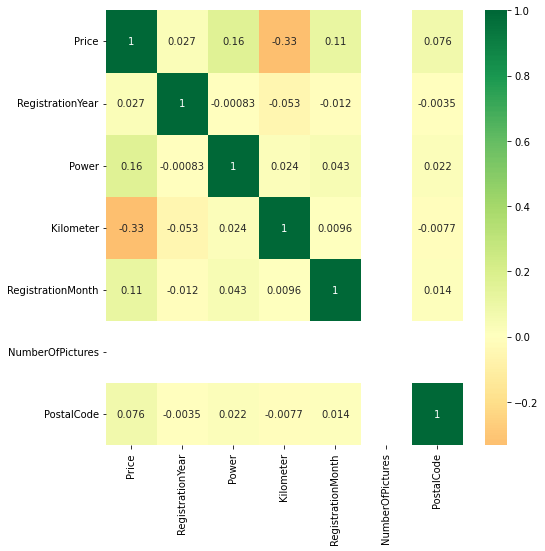

In [5]:
check (df)

First conclutions:

* In RegistrationYear (car registration), the minimum value is 1000, the maximum is 9999, this is an error, I'll delete the extra ones. Last year in data 2016;
* In Power (power), the minimum is 0, and the maximum is 20000. Power is in horsepower, so 0 is definitely an error, but the value of 20000 is also. The most powerful consumer cars are up to 1000 hp and that's rare. ;
* There are no values in the NumberOfPictures column. I will delete this column;
* In Price there is an abnormal value of 0, this is an error. In this column, it will be difficult to correctly remove unnecessary data, since it is difficult to estimate the minimum price for a used car, it can be sold for restoration.
* There is 0 in the RegistrationMonth column, which probably means no data;
* Columns: VehicleType, Gearbox, Model, FuelType, NotRepaired have missing values;
* The Kilometer column has 50.75 quantiles and a maximum value of 150,000 km, there is probably a pattern when filling in the data - 'mileage is more than 150,000 km'
* There are 4 duplicates

Removing duplicates and check

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.duplicated().sum()

0

In [8]:
df.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'NotRepaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Checking values in the year of registration

In [9]:
df ['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

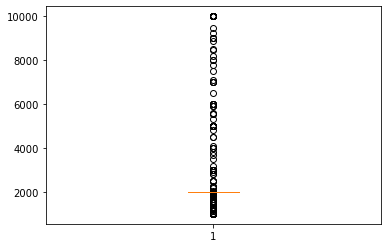

In [10]:
plt.boxplot(df ['RegistrationYear'])
plt.show()

First car available for purchase -  "Motorwagen" appeared in 1886, but full-fledged serial production begins after 1900, there are no values between 1800 and 1910, so I make cutoff 1886.
I put the upper cut-off in 2016 inclusive, this is the last year of data according to description.

In [11]:
df1 = df.loc[(df['RegistrationYear'] >= 1886) & (df['RegistrationYear'] <= 2016)]

In [12]:
df1 ['RegistrationYear'].sort_values().unique()

array([1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931,
       1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943,
       1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954,
       1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965,
       1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976,
       1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987,
       1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998,
       1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,
       2010, 2011, 2012, 2013, 2014, 2015, 2016])

Power in data goes from 0 to 20000

In [13]:
df ['Power'].sort_values().unique()

array([    0,     1,     2,     3,     4,     5,     6,     7,     8,
           9,    10,    11,    12,    13,    14,    15,    16,    17,
          18,    19,    20,    21,    22,    23,    24,    25,    26,
          27,    28,    29,    30,    31,    32,    33,    34,    35,
          36,    37,    38,    39,    40,    41,    42,    43,    44,
          45,    46,    47,    48,    49,    50,    51,    52,    53,
          54,    55,    56,    57,    58,    59,    60,    61,    62,
          63,    64,    65,    66,    67,    68,    69,    70,    71,
          72,    73,    74,    75,    76,    77,    78,    79,    80,
          81,    82,    83,    84,    85,    86,    87,    88,    89,
          90,    91,    92,    93,    94,    95,    96,    97,    98,
          99,   100,   101,   102,   103,   104,   105,   106,   107,
         108,   109,   110,   111,   112,   113,   114,   115,   116,
         117,   118,   119,   120,   121,   122,   123,   124,   125,
         126,   127,

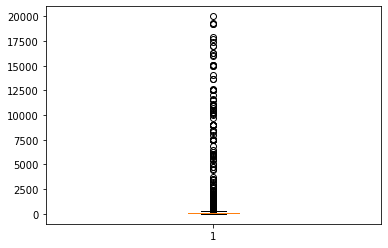

In [14]:
plt.boxplot(df ['Power'])
plt.show()

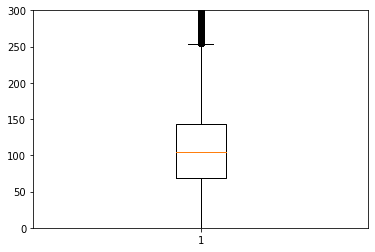

In [15]:
plt.boxplot(df ['Power'])
plt.ylim(0, 300)
plt.show()

The main values range from about 75 to 125.
After reviewing the popular site Autoscout, I saw that there are really a lot of offers with unrealistic values in the region from 1 to 50 hp, so it would be dangerous to cut off this data, I set the lower limit from 1 inclusive.
I set the upper limit at 1000 hp, for mass-produced cars this is almost the maximum.

In [16]:
df1 = df1.loc[(df1['Power'] >= 1) & (df1['Power'] <= 1000)]

The situation is similar with the price, as with power, there are indeed offers on the sites for 1 euro, these are problematic cars, but there is no sale for 0 euro, so I remove the values with a price of 0 euro.

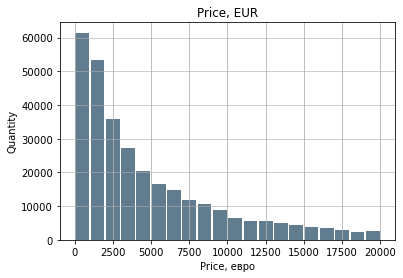

In [17]:
df1 ['Price'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Price, EUR')
plt.xlabel('Price, евро')
plt.ylabel('Quantity')
plt.grid(axis='y', alpha=0.75)

I check what values are in the range from 1 to 50, there are different models, both new and old, repaired and not, it’s impossible to say unequivocally that this is an error, so I leave it.

In [18]:
df1 [(df1['Price']<50) & (df1['Price']>1)]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1025,2016-03-15 18:57:12,3,convertible,1998,manual,110,mx_reihe,150000,11,NaN,mazda,yes,2016-03-15 00:00:00,0,89312,2016-04-06 21:16:58
1634,2016-03-13 03:36:19,2,bus,2004,manual,135,scenic,150000,0,petrol,renault,NaN,2016-03-13 00:00:00,0,30926,2016-04-02 15:17:36
3071,2016-03-24 19:57:53,30,sedan,1995,manual,75,polo,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,59067,2016-04-05 13:16:29
3742,2016-03-23 17:30:02,2,sedan,2002,auto,272,7er,5000,9,petrol,bmw,NaN,2016-03-23 00:00:00,0,65183,2016-03-24 21:28:34
6669,2016-03-23 12:40:54,9,small,1994,manual,90,golf,150000,9,petrol,volkswagen,no,2016-03-23 00:00:00,0,3054,2016-04-05 11:18:19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342742,2016-03-13 02:57:07,3,sedan,2007,manual,65,clio,125000,3,petrol,renault,no,2016-03-13 00:00:00,0,41334,2016-03-15 15:15:16
343524,2016-04-05 09:36:24,10,NaN,2000,NaN,170,vectra,150000,12,NaN,opel,NaN,2016-04-05 00:00:00,0,93449,2016-04-07 13:17:27
349043,2016-03-26 11:39:00,10,small,1999,NaN,75,NaN,150000,0,NaN,volkswagen,no,2016-03-26 00:00:00,0,85221,2016-04-05 22:45:11
351442,2016-03-11 08:55:34,20,NaN,1970,NaN,55,NaN,150000,8,NaN,opel,NaN,2016-03-11 00:00:00,0,59872,2016-04-06 11:45:55


Therefore, in order not to cut off useful information, I remove only zero values

In [19]:
df1 = df1.loc[df1['Price'] >= 1]

In [20]:
df1.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,296633.000000,296633.000000,296633.000000,296633.000000,296633.000000,296633.0,296633.000000
mean,4854.625099,2002.815206,120.727377,128260.443039,5.992890,0.0,51237.013188
std,4612.152399,6.558912,54.852889,36808.502616,3.584171,0.0,25782.950105
min,1.000000,1910.000000,1.000000,5000.000000,0.000000,0.0,1067.000000
25%,1350.000000,1999.000000,75.000000,125000.000000,3.000000,0.0,30926.000000
50%,3200.000000,2003.000000,111.000000,150000.000000,6.000000,0.0,50259.000000
75%,6999.000000,2007.000000,150.000000,150000.000000,9.000000,0.0,72108.000000
max,20000.000000,2016.000000,1000.000000,150000.000000,12.000000,0.0,99998.000000


Missing values

In [21]:
df1.isnull().sum().sort_values(ascending = False)

NotRepaired          42980
FuelType             15594
Model                11209
VehicleType          11057
Gearbox               5391
DateCrawled              0
Price                    0
RegistrationYear         0
Power                    0
Kilometer                0
RegistrationMonth        0
Brand                    0
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [22]:
def func (dataframe):
    display (dataframe.value_counts(normalize=True))

In the repair feature only options 'yes' and 'no', missinf values probably mean 'no information', so I fill it with 'no info'

In [23]:
func(df1['NotRepaired'])

no     0.885848
yes    0.114152
Name: NotRepaired, dtype: float64

In [24]:
df1['NotRepaired'] = df1['NotRepaired'].fillna('no info')

There is a 'other' in type of fuel, which means that all missing values are the lack of information, I also change it to no information.

In [25]:
func(df1['FuelType'])

petrol      0.667648
gasoline    0.312636
lpg         0.016677
cng         0.001719
hybrid      0.000719
other       0.000331
electric    0.000270
Name: FuelType, dtype: float64

In [26]:
df1['FuelType'] = df1['FuelType'].fillna('no info')

There is 'other' the type of machine, which means that all the missing values are the lack of information, I also change the information to 'no info', similar to the type of machine.

In [27]:
func(df1['VehicleType'])

sedan          0.290984
small          0.245567
wagon          0.207573
bus            0.091804
convertible    0.065741
coupe          0.051202
suv            0.038389
other          0.008740
Name: VehicleType, dtype: float64

In [28]:
df1['VehicleType'] = df1['VehicleType'].fillna('no info')

In the values of the model, specific names, which means missing info are the lack of information, I change to no information.

In [29]:
func(df1['Model'])

golf                  0.086643
other                 0.071700
3er                   0.060920
polo                  0.037474
corsa                 0.035509
                        ...   
serie_2               0.000018
kalina                0.000018
serie_3               0.000011
range_rover_evoque    0.000007
rangerover            0.000007
Name: Model, Length: 249, dtype: float64

In [30]:
df1['Model'] = df1['Model'].fillna('no info')

In the type of gearbox, it can be assumed that there is also a variator, but probably it is part of an automatic transmission, I also change to 'no info'.

In [31]:
func(df1['Gearbox'])

manual    0.797581
auto      0.202419
Name: Gearbox, dtype: float64

In [32]:
df1['Gearbox'] = df1['Gearbox'].fillna('no info')

Final check of missing values

In [33]:
df1.isnull().sum().sort_values(ascending = False)

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

## Model training

In [34]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296633 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        296633 non-null  object
 1   Price              296633 non-null  int64 
 2   VehicleType        296633 non-null  object
 3   RegistrationYear   296633 non-null  int64 
 4   Gearbox            296633 non-null  object
 5   Power              296633 non-null  int64 
 6   Model              296633 non-null  object
 7   Kilometer          296633 non-null  int64 
 8   RegistrationMonth  296633 non-null  int64 
 9   FuelType           296633 non-null  object
 10  Brand              296633 non-null  object
 11  NotRepaired        296633 non-null  object
 12  DateCreated        296633 non-null  object
 13  NumberOfPictures   296633 non-null  int64 
 14  PostalCode         296633 non-null  int64 
 15  LastSeen           296633 non-null  object
dtypes: int64(7), object(

Remove unwanted columns:
* DateCrawled - date of downloading the questionnaire - does not affect the price
* NumberOfPictures - would be important, but there is no information in it
* PostalCode - postal code of the owner, does not affect. If there was a region of sale, this would affect
* LastSeen - the date of the last presence on the site is not needed
* DateCreated - has no significant effect on the price
* RegistrationMonth - does not affect the price, year of production is main indicator

In [35]:
df1 = df1.drop (['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'DateCreated', 'RegistrationMonth'],axis = 1)


Change data type object to category

In [36]:
for col in ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']:
    df1[col] = df1[col].astype('category')

Features, target split

In [37]:
target = df1['Price']
features = df1.drop('Price', axis=1)

Proportion of split 60/20/20 training / validation / test

In [38]:
features_train, x_valid, target_train, y_valid = train_test_split(
   features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    x_valid,y_valid, test_size=0.5, random_state=12345)

In [39]:
features_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 177979 entries, 326694 to 259860
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   VehicleType       177979 non-null  category
 1   RegistrationYear  177979 non-null  int64   
 2   Gearbox           177979 non-null  category
 3   Power             177979 non-null  int64   
 4   Model             177979 non-null  category
 5   Kilometer         177979 non-null  int64   
 6   FuelType          177979 non-null  category
 7   Brand             177979 non-null  category
 8   NotRepaired       177979 non-null  category
dtypes: category(6), int64(3)
memory usage: 6.6 MB


I encode categorical variables using the OrdinalEncoder method

In [40]:
encoder = OrdinalEncoder()
cat_columns = ['VehicleType','FuelType','Brand','Model', 'Gearbox','NotRepaired']
#train
cat_features_train = features_train[cat_columns]
cat_features_train = pd.DataFrame(encoder.fit_transform(cat_features_train),
                                columns=cat_features_train.columns, 
                                index=cat_features_train.index)
features_train_OE = features_train.copy()
for column in cat_columns:
    features_train_OE[column] = cat_features_train[column]
#test
cat_features_test = features_test[cat_columns]
cat_features_test = pd.DataFrame(encoder.fit_transform(cat_features_test),
                                columns=cat_features_test.columns, 
                                index=cat_features_test.index)
features_test_OE = features_test.copy()
for column in cat_columns:
    features_test_OE[column] = cat_features_test[column]
#valid
cat_features_valid = features_valid[cat_columns]
cat_features_valid = pd.DataFrame(encoder.fit_transform(cat_features_valid),
                                columns=cat_features_valid.columns, 
                                index=cat_features_valid.index)
features_valid_OE = features_valid.copy()
for column in cat_columns:
    features_valid_OE[column] = cat_features_valid[column]

In [41]:
features_train_OE

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
326694,6.0,2001,1.0,80,177.0,150000,7.0,9.0,2.0
262927,6.0,2010,1.0,84,45.0,150000,4.0,3.0,2.0
178861,8.0,2000,0.0,136,59.0,150000,4.0,20.0,0.0
51125,8.0,1997,1.0,136,165.0,150000,7.0,24.0,1.0
318799,6.0,2004,1.0,37,143.0,150000,7.0,38.0,2.0
...,...,...,...,...,...,...,...,...,...
189718,8.0,1999,1.0,136,161.0,150000,5.0,2.0,2.0
57321,5.0,1998,1.0,75,42.0,150000,7.0,24.0,0.0
103194,5.0,2005,1.0,105,28.0,150000,2.0,1.0,1.0
92371,8.0,1998,1.0,101,164.0,150000,7.0,31.0,1.0


I perform OHE coding of categorical variables for a linear model

In [42]:
features_train_ohe = pd.get_dummies(features_train, drop_first = True)
features_test_ohe = pd.get_dummies(features_test, drop_first = True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first = True)

In [43]:
print(f'Train size: {features_train.shape[0] / df1.shape[0]:.1%}')
print(f'Valid size: {features_valid.shape[0] / df1.shape[0]:.1%}')
print(f'Test size: {features_test.shape[0] / df1.shape[0]:.1%}')

Train size: 60.0%
Valid size: 20.0%
Test size: 20.0%


Scale numeric variables

In [44]:
pd.options.mode.chained_assignment = None
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

### Linear Regression

In [45]:
LRmodel = LinearRegression()

Train model and measure time for training and prediction

In [46]:
tic_LRfit = time.time()
LRmodel.fit(features_train_ohe, target_train)
toc_LRfit = time.time()
time_taken_LRfit = toc_LRfit - tic_LRfit 

Training time in seconds here and after

In [47]:
time_taken_LRfit

2.9043691158294678

In [48]:
tic_LRpred = time.time()

predictions_valid_LR = LRmodel.predict(features_valid_ohe)
RMSE_LR = mean_squared_error(target_valid, predictions_valid_LR)**0.5
RMSE_LR
toc_LRpred = time.time()
time_taken_LRpred = toc_LRpred - tic_LRpred 

In [49]:
RMSE_LR

2615.3968895126113

Time spent on prediction in seconds

In [50]:
time_taken_LRpred

0.30017685890197754

The model has a long training and prediction time. The RMSE parameter is comparable with further models.

### Random Forest

In [51]:
RFmodel = RandomForestRegressor(random_state=42, n_estimators=15, max_depth = 20)

In [52]:
tic_RFmodel = time.time()
RFmodel.fit(features_train_ohe, target_train)
toc_RFmodel = time.time()
time_taken_RFmodel = toc_LRfit - tic_LRfit 

In [53]:
time_taken_RFmodel

2.9043691158294678

In [54]:
tic_RFmodel_pred = time.time()
predictions_valid_RF = RFmodel.predict(features_valid_ohe)
RMSE_RF = mean_squared_error(target_valid, predictions_valid_RF)**0.5
toc_RFmodel_pred = time.time()
time_taken_RFmodel_pred = toc_RFmodel_pred - tic_RFmodel_pred 

In [55]:
time_taken_RFmodel_pred

0.3740661144256592

The root mean square error (RMSE) is significantly lower than that of linear regression. Try to tune model

In [56]:
RMSE_RF

1631.0648964234088

In [57]:
regressor = RandomForestRegressor() 
max_depth_list = [x for x in range(20,36,5)]
n_estimators_list = [x for x in range(15, 26,5)]
hyperparams = [{'criterion':['squared_error'], 
                'n_estimators': [15],
                'max_depth':n_estimators_list, 
                'random_state':[42]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train_ohe, target_train)
print(clf.best_params_)

{'criterion': 'squared_error', 'max_depth': 25, 'n_estimators': 15, 'random_state': 42}


In [58]:
RFmodel1 = RandomForestRegressor(criterion='squared_error', 
                              max_depth=21,
                                 n_estimators = 15,
                              random_state=19072020)

In [59]:
tic_RFmodel1 = time.time()
RFmodel1.fit(features_train_ohe, target_train)
toc_RFmodel1 = time.time()
time_taken_RFmodel1 = toc_RFmodel1 - tic_RFmodel1

In [60]:
time_taken_RFmodel1

43.103461027145386

In [61]:
tic_RFmodel1_pred = time.time()
predictions_valid_RF1 = RFmodel1.predict(features_valid_ohe)
RMSE_RF1 = mean_squared_error(target_valid, predictions_valid_RF1)**0.5
toc_RFmodel1_pred = time.time()
time_taken_RFmodel1_pred = toc_RFmodel1_pred - tic_RFmodel1_pred 

In [62]:
time_taken_RFmodel1_pred

0.41583895683288574

Root mean square error is even lower

In [63]:
RMSE_RF1

1622.9710895196968

### LGBM 

In [64]:
tic_LGBMmodel_fit = time.time()

LGBM_model = LGBMRegressor(random_state=42)
LGBM_model.fit(features_train, target_train)
toc_LGBMmodel_fit = time.time()
time_taken_LGBMmodel_fit = toc_LGBMmodel_fit - tic_LGBMmodel_fit 

In [65]:
time_taken_LGBMmodel_fit

1.0275077819824219

In [66]:
tic_LGBMmodel_pred = time.time()

predictions_valid_LGBM = LGBM_model.predict(features_valid)
RMSE_LGBN = mean_squared_error(target_valid, predictions_valid_LGBM)**0.5

toc_LGBMmodel_pred = time.time()
time_taken_LGBMmodel_pred = toc_LGBMmodel_pred - tic_LGBMmodel_pred 

In [67]:
RMSE_LGBN

1619.4911348402961

In [68]:
time_taken_LGBMmodel_pred

0.12155818939208984

Selecting hyperparameters to improve the result

In [69]:
regressor = LGBMRegressor() 
hyperparams = [{'num_leaves':[50, 100, 300], 
                'learning_rate':[0.05, 0.1, 0.3],
                'max_depth': [-1, 100,600],
                'random_state':[42]}]

clf = GridSearchCV(regressor, hyperparams, scoring='neg_mean_squared_error')
clf.fit(features_train, target_train)
print(clf.best_params_)

{'learning_rate': 0.1, 'max_depth': -1, 'num_leaves': 300, 'random_state': 42}


In [70]:
LGBM_model1 = LGBMRegressor(learning_rate=0.1,
                            max_depth=-1,
                      num_leaves=300, 
                      random_state=19072020)

In [71]:
tic_LGBMmodel1_fit = time.time()
LGBM_model1.fit(features_train, target_train)
toc_LGBMmodel1_fit = time.time()
time_taken_LGBMmodel1_fit = toc_LGBMmodel1_fit - tic_LGBMmodel1_fit

In [72]:
time_taken_LGBMmodel1_fit

7.534088134765625

In [73]:
tic_LGBMmodel1_pred = time.time()
predictions_valid_LGBM1 = LGBM_model1.predict(features_valid)
RMSE_LGBN1 = mean_squared_error(target_valid, predictions_valid_LGBM1)**0.5
toc_LGBMmodel1_pred = time.time()
time_taken_LGBMmodel1_pred = toc_LGBMmodel1_pred - tic_LGBMmodel1_pred 

In [74]:
time_taken_LGBMmodel1_pred

0.30095410346984863

In [75]:
RMSE_LGBN1

1528.0833517195313

RMSE is significantly better than previous models

### Catboost 

In [76]:
tic_CBMmodel_fit = time.time()
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

catboost_model = CatBoostRegressor(random_state=42,silent=True)
catboost_model.fit(features_train, target_train, cat_features=cat_features)
toc_CBmodel_fit = time.time()
time_taken_CBmodel_fit = toc_CBmodel_fit - tic_CBMmodel_fit 

In [77]:
time_taken_CBmodel_fit

72.50722980499268

In [78]:
tic_CBmodel_pred = time.time()

predictions_valid_cat = catboost_model.predict(features_valid)
RMSE_CB = mean_squared_error(target_valid, predictions_valid_cat)**0.5

toc_CBmodel_pred = time.time()
time_taken_CBmodel_pred = toc_CBmodel_pred - tic_CBmodel_pred 

In [79]:
RMSE_CB

1597.1711627215734

In [80]:
time_taken_CBmodel_pred

0.23271703720092773

Trying to improve the model so that the root mean square error (RMSE) becomes even smaller

In [81]:
train_data = Pool(data=features_train,
              label=target_train,
              cat_features = cat_features
              )

test_data = Pool(data=features_valid,
              label=target_valid,
              cat_features = cat_features
              )

model_params = {'random_state': 42,
                'eval_metric': 'RMSE',
                'verbose': 100,
                'cat_features': cat_features,
                'loss_function': 'RMSE',
                'learning_rate': 0.3}

cv_params = {'params': model_params,
             'pool': train_data,
             'fold_count': 3,
             'shuffle':True,
             'partition_random_seed':42,
             'verbose': 100,
             'early_stopping_rounds':200}

cv_data = cv(**cv_params)

Training on fold [0/3]
0:	learn: 5094.1470318	test: 5031.7576378	best: 5031.7576378 (0)	total: 102ms	remaining: 1m 41s
100:	learn: 1641.2669097	test: 1665.0912470	best: 1665.0912470 (100)	total: 6.28s	remaining: 55.9s
200:	learn: 1570.8816225	test: 1626.7428600	best: 1626.7428600 (200)	total: 12.3s	remaining: 49s
300:	learn: 1528.4719081	test: 1607.9916730	best: 1607.9916730 (300)	total: 18.1s	remaining: 42s
400:	learn: 1497.8226114	test: 1596.5653556	best: 1596.5291141 (394)	total: 24s	remaining: 35.9s
500:	learn: 1472.0344347	test: 1590.9583285	best: 1590.8374093 (498)	total: 30.2s	remaining: 30.1s
600:	learn: 1450.8284487	test: 1585.0822660	best: 1584.9710763 (585)	total: 36.4s	remaining: 24.2s
700:	learn: 1431.0128585	test: 1580.7395938	best: 1580.6670639 (697)	total: 42.5s	remaining: 18.1s
800:	learn: 1412.6011245	test: 1578.1581732	best: 1578.1581732 (800)	total: 48.7s	remaining: 12.1s
900:	learn: 1398.1176353	test: 1576.8489249	best: 1576.8209457 (864)	total: 54.4s	remaining: 5.

In [82]:
catboost_model1 = CatBoostRegressor(**model_params)

In [83]:
tic_CBMmodel_fit1 = time.time()
catboost_model1.fit(features_train, target_train)
toc_CBmodel_fit1 = time.time()
time_taken_CBmodel_fit1 = toc_CBmodel_fit1 - tic_CBMmodel_fit1

0:	learn: 3740.7143902	total: 86.3ms	remaining: 1m 26s
100:	learn: 1630.3115581	total: 7.41s	remaining: 1m 5s
200:	learn: 1566.8567320	total: 14.3s	remaining: 57s
300:	learn: 1527.5596994	total: 21.4s	remaining: 49.8s
400:	learn: 1501.3280989	total: 28.7s	remaining: 42.8s
500:	learn: 1479.0032733	total: 36.3s	remaining: 36.2s
600:	learn: 1459.7420719	total: 43.6s	remaining: 29s
700:	learn: 1443.3022516	total: 50.9s	remaining: 21.7s
800:	learn: 1430.4973109	total: 58.6s	remaining: 14.6s
900:	learn: 1418.9721742	total: 1m 6s	remaining: 7.26s
999:	learn: 1408.6075253	total: 1m 13s	remaining: 0us


In [84]:
tic_CBmodel_pred1 = time.time()
predictions_valid_cat1 = catboost_model1.predict(features_valid)
RMSE_CB1 = mean_squared_error(target_valid, predictions_valid_cat1)**0.5
toc_CBmodel_pred1 = time.time()
time_taken_CBmodel_pred1 = toc_CBmodel_pred1 - tic_CBmodel_pred1

Root mean square error (RMSE) has decreased even more, making a pivot table with all models

In [85]:
RMSE_CB1

1569.8059235424394

In [86]:
time_taken_CBmodel_pred1

0.293212890625

In [87]:
model_1 = {'Train time, sec': time_taken_LGBMmodel_fit,
            'Prediction time, sec': time_taken_LGBMmodel_pred,
            'RMSE': RMSE_LGBN}
model_2 = {'Train time, sec': time_taken_LGBMmodel1_fit,
            'Prediction time, sec': time_taken_LGBMmodel_pred,
            'RMSE': RMSE_LGBN1}
model_3 = {'Train time, sec': time_taken_LRfit,
            'Prediction time, sec': time_taken_LRpred,
              'RMSE': RMSE_LR}
model_4 = {'Train time, sec': time_taken_RFmodel,
            'Prediction time, sec': time_taken_RFmodel_pred,
              'RMSE': RMSE_RF}
model_5 = {'Train time, sec': time_taken_RFmodel1,
            'Prediction time, sec': time_taken_RFmodel1_pred,
              'RMSE': RMSE_RF1}
model_6 = {'Train time, sec': time_taken_CBmodel_fit,
            'Prediction time, sec': time_taken_CBmodel_pred,
              'RMSE': RMSE_CB}
model_7 = {'Train time, sec': time_taken_CBmodel_fit1,
            'Prediction time, sec': time_taken_CBmodel_pred1,
              'RMSE': RMSE_CB1}

In [88]:
Models = pd.DataFrame([model_1, model_2, model_3, model_4, model_5, model_6, model_7], 
                      index=['LightGBM', 'LightGBM_tune','LinearRegression', 'RandomForest','RandomForest_tune', 'CatBoost','CatBoost_cv'])

## Model analyze

In [89]:
Models

,"Train time, sec","Prediction time, sec",RMSE
LightGBM,1.027508,0.121558,1619.491135
LightGBM_tune,7.534088,0.121558,1528.083352
LinearRegression,2.904369,0.300177,2615.396890
RandomForest,2.904369,0.374066,1631.064896
RandomForest_tune,43.103461,0.415839,1622.971090
CatBoost,72.507230,0.232717,1597.171163
CatBoost_cv,75.060106,0.293213,1569.805924


Based on the RMSE parameter, the leader is LightGBM with fitted hyperparameters, next is the CatBoost model with cross-validation. In terms of training and prediction time, LGBM is significantly faster than CatBoost.

Checking the two best models on a test sample. The result of the LGBM model is again better, RMSE is lower.

In [90]:
predictions_test_CB = catboost_model1.predict(features_test)
RMSE = mean_squared_error(target_test, predictions_test_CB)**0.5
RMSE

1573.1662523602163

In [91]:
predictions_test_LGBM = LGBM_model1.predict(features_test)
RMSE1 = mean_squared_error(target_test, predictions_test_LGBM)**0.5
RMSE1

1525.6897398794208

## Conclusion

Steps were taken:

Data loaded, preprocessing performed (duplicates removed, missing values replaced).
Models trained with default parameters and additionally using different sets of hyperparameters.
The best model was selected based on the results of the RMSE metric and training time.

The best model is LGBM.

Based on this, the general recommendation is:

As a model to use for predicting used car prices, it is recommended to choose LGBM with fitted hyperparameters.